In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# ---- 시계열 딥러닝 모델 평가 통합 함수 ----
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, Flatten, Input, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


# ---- 머신러닝 모델 평가 통합 함수 ----
def ml_models_compare(
    X, y,
    models=('rf', 'xgb', 'lgbm', 'plsr', 'lr'),
    scaling='standard',
    test_size=0.2,
    random_state=42,
    model_params=None,
    plot=False,
):
    if model_params is None: model_params = {}
    results = []
    # scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = None
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'minmax':
        scaler = MinMaxScaler()
    if scaler:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
    for mtype in models:
        if mtype == 'rf':
            model = RandomForestRegressor(n_estimators=300, random_state=random_state, **model_params.get('rf', {}))
        elif mtype == 'xgb':
            model = xgb.XGBRegressor(n_estimators=300, random_state=random_state, **model_params.get('xgb', {}))
        elif mtype == 'lgbm':
            model = lgb.LGBMRegressor(n_estimators=300, random_state=random_state, **model_params.get('lgbm', {}))
        elif mtype == 'plsr':
            model = PLSRegression(n_components=min(5, X_train.shape[1]), **model_params.get('plsr', {}))
        elif mtype == 'lr':
            model = LinearRegression()
        else:
            raise ValueError(mtype)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({'model': mtype, 'rmse': rmse, 'r2': r2})
        # Optional: plot 예측치
        if plot:
            plt.figure()
            plt.scatter(y_test, y_pred, alpha=0.7)
            plt.xlabel('True')
            plt.ylabel('Pred')
            plt.title(f'{mtype.upper()} Prediction')
            plt.grid(True)
            plt.show()
    result_df = pd.DataFrame(results)
    return result_df
# ---- 머신러닝 Feature Importance 분석 함수 ----
def ml_models_performance_curve(
    X, y, 
    model_type='rf',      # 'rf', 'xgb', 'lgbm', 'plsr', 'lr' 등
    test_size=0.2,
    random_state=42,
    max_num_features=None,
    plot=True,
    scaling=None,         # None, 'standard', 'minmax'
    model_params=None
):
    assert model_type in ['rf', 'xgb', 'lgbm', 'plsr', 'lr'], "model_type invalid"
    if model_params is None: model_params = {}
    # 스케일링
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    scaler = None
    if scaling is not None:
        if scaling == "standard": scaler = StandardScaler()
        elif scaling == "minmax": scaler = MinMaxScaler()
        else: raise ValueError("scaling: None/'standard'/'minmax'")
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    # 피처 선택용 모델
    if model_type == 'rf':
        model_default = RandomForestRegressor(n_estimators=300, random_state=random_state, **model_params)
        model_importance = lambda m: m.feature_importances_
    elif model_type == 'xgb':
        model_default = xgb.XGBRegressor(n_estimators=300, random_state=random_state, **model_params)
        model_importance = lambda m: m.feature_importances_
    elif model_type == 'lgbm':
        model_default = lgb.LGBMRegressor(n_estimators=300, random_state=random_state, **model_params)
        model_importance = lambda m: m.feature_importances_
    elif model_type == 'plsr':
        # PLSR은 feature importance 값이 없음(아래 feature importance는 생략)
        model_default = PLSRegression(n_components=min(X.shape[1], 5), **model_params)
        model_importance = lambda m: np.zeros(X.shape[1])
    elif model_type == 'lr':
        model_default = LinearRegression()
        model_importance = lambda m: np.abs(m.coef_)
    # 피처 임포턴스 기반 정렬
    model_default.fit(X_train, y_train)
    importances = model_importance(model_default)
    feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
    # feature 개수별 성능 곡선
    if max_num_features is None: max_num_features = len(X.columns)
    rmse_results, r2_results = [], []
    num_features_list = list(range(1, max_num_features+1))
    for n_features in num_features_list:
        top_features = feature_importance_df['feature'].iloc[:n_features].tolist()
        X_train_sub, X_test_sub = X_train[top_features], X_test[top_features]
        if model_type == 'rf':
            model = RandomForestRegressor(n_estimators=300, random_state=random_state, **model_params)
        elif model_type == 'xgb':
            model = xgb.XGBRegressor(n_estimators=300, random_state=random_state, **model_params)
        elif model_type == 'lgbm':
            model = lgb.LGBMRegressor(n_estimators=300, random_state=random_state, **model_params)
        elif model_type == 'plsr':
            model = PLSRegression(n_components=min(n_features,5), **model_params)
        elif model_type == 'lr':
            model = LinearRegression()
        model.fit(X_train_sub, y_train)
        y_pred = model.predict(X_test_sub)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        rmse_results.append(rmse)
        r2_results.append(r2)
    # 결과 데이터 프레임
    result_df = pd.DataFrame({
        'num_features': num_features_list,
        'RMSE': rmse_results,
        'R2': r2_results
    })
    # Plot
    if plot:
        fig, ax1 = plt.subplots(figsize=(8, 5))
        color1, color2 = 'tab:blue', 'tab:red'
        ax1.set_xlabel('Number of Features (top-N-selected)')
        ax1.set_ylabel('RMSE', color=color1)
        ax1.plot(num_features_list, rmse_results, marker='o', color=color1, label='RMSE')
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.invert_xaxis()
        ax2 = ax1.twinx()
        ax2.set_ylabel('R2 Score', color=color2)
        ax2.plot(num_features_list, r2_results, marker='s', color=color2, label='R2 Score')
        ax2.tick_params(axis='y', labelcolor=color2)
        fig.suptitle(f'Model Performance vs. Number of Features ({model_type.upper()})')
        fig.tight_layout()
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.show()
        if np.any(feature_importance_df['importance'] != 0):
            plt.figure(figsize=(8,5))
            top_show = min(20, len(feature_importance_df))
            plt.barh(feature_importance_df['feature'][:top_show], feature_importance_df['importance'][:top_show], color='skyblue')
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_show} Feature Importances ({model_type.upper()})')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
    return result_df, feature_importance_df
# ---- 시계열 딥러닝 모델 평가 함수 ----
def dl_seq_train(
    X_seq, y_seq,
    model_type='lstm',
    n_units=32,
    epochs=20,
    batch_size=32,
    test_size=0.2,
    random_state=42,
    scaling='standard',
    plot=False
):
    # scaling
    scaler = None
    if scaling:
        flatX = X_seq.reshape(-1, X_seq.shape[-1])
        if scaling == 'standard':
            scaler = StandardScaler()
        elif scaling == 'minmax':
            scaler = MinMaxScaler()
        scaler.fit(flatX)
        X_seq = scaler.transform(flatX).reshape(X_seq.shape)
    # data split
    np.random.seed(random_state)
    idx = np.arange(len(X_seq))
    np.random.shuffle(idx)
    n_train = int(len(idx)*(1-test_size))
    train_idx, test_idx = idx[:n_train], idx[n_train:]
    X_train, y_train = X_seq[train_idx], y_seq[train_idx]
    X_test, y_test = X_seq[test_idx], y_seq[test_idx]
    T, D = X_seq.shape[1], X_seq.shape[2]
    # Model build
    if model_type == 'mlp':
        model = Sequential([
            Flatten(input_shape=(T, D)),
            Dense(n_units, activation='relu'),
            Dropout(0.1),
            Dense(n_units, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'cnn':
        model = Sequential([
            Conv1D(32, 5, activation='relu', input_shape=(T, D)),
            BatchNormalization(),
            Conv1D(16, 3, activation='relu'),
            GlobalAveragePooling1D(),
            Dense(n_units, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'lstm':
        model = Sequential([
            LSTM(n_units, input_shape=(T, D)),
            Dense(1)
        ])
    elif model_type == 'gru':
        model = Sequential([
            GRU(n_units, input_shape=(T, D)),
            Dense(1)
        ])
    elif model_type == 'cnn_lstm':
        model = Sequential([
            Conv1D(32, 5, activation='relu', input_shape=(T, D)),
            BatchNormalization(),
            Conv1D(16, 3, activation='relu'),
            LSTM(n_units),
            Dense(1)
        ])
    else:
        raise ValueError(model_type)
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.15)
    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    if plot:
        plt.figure(figsize=(6,4))
        plt.plot(y_test, label='True')
        plt.plot(y_pred, label='Pred')
        plt.title(f'{model_type.upper()} Prediction')
        plt.xlabel('Sample Index')
        plt.ylabel('Target')
        plt.legend()
        plt.tight_layout()
        plt.show()
    return model, rmse, r2
# ---- 시계열 데이터 sample별 집합 ----
def make_sequence_by_sample(x_df, y_df, sample_col='Sample_Number', time_col='time', feature_cols=None):
    if feature_cols is None:
        ignore_cols = [sample_col, time_col]
        feature_cols = [
            c for c in x_df.select_dtypes(include=[np.number]).columns 
            if c not in ignore_cols
        ]
    x_df['_sort_time'] = x_df[time_col]
    Xs, ys = [], []
    for sn, group in x_df.groupby(sample_col):
        group = group.sort_values('_sort_time')
        X_seq = group[feature_cols].values
        y_row = y_df[y_df[sample_col]==sn]
        if y_row.shape[0] == 0: continue
        y_val = y_row.iloc[0, -1]
        Xs.append(X_seq)
        ys.append(y_val)
    # 시계열 샘플 수 맞춤
    if all([x.shape == Xs[0].shape for x in Xs]):
        X_result = np.stack(Xs)
    else:
        maxlen = max(x.shape[0] for x in Xs)
        n_feat = Xs[0].shape[1]
        X_result = np.zeros((len(Xs), maxlen, n_feat))
        for i, arr in enumerate(Xs):
            X_result[i, :arr.shape[0], :] = arr
    y_result = np.array(ys)
    return X_result, y_result


## 데이터 로딩 + 피쳐 선택

In [2]:
# (1) 데이터 로딩(요 데이터만 바꿔주세요) #
x_df = pd.read_csv(r'C:\Users\totso\OneDrive\Temporary\문서\GitHub\digiai2025\사전테스트\x_train.csv')
y_df = pd.read_csv(r'C:\Users\totso\OneDrive\Temporary\문서\GitHub\digiai2025\사전테스트\y_train.csv')

x_df['datetime'] = pd.to_datetime("2025-01-01 " + x_df['time'])
group_col = 'Sample_Number'
numeric_cols = x_df.select_dtypes(include='number').columns.tolist()
agg_cols = [col for col in numeric_cols if col != group_col]

x_sample = x_df.groupby(group_col)[agg_cols].mean().reset_index()
y_sample = y_df.groupby('Sample_Number').mean().reset_index()
merged_df = pd.merge(x_sample, y_sample, on='Sample_Number', how='inner')

exclude_cols = ['Sample_Number', 'CO2 final', 'numbers of plant', 'date', 'DAT']
y_col = 'CO2 final'
feature_cols = [c for c in merged_df.columns if c not in exclude_cols]

X = merged_df[feature_cols]
y = merged_df[y_col]

# (2) 피쳐 수동 선택
my_features = [
    'fan', 'co2', 'heater', 'window1', 'window2', 'curtain1', 'curtain2', 'curtain3', 'side_curtain',
    'in_temp', 'in_hum', 'in_co2', 'out_temp', 'out_hum',
    'solar_rad', 'wind_speed', 'wind_direction', 'rain_sensor'
    # ... 원하면 더 추가/제외OK
]




## 머신러닝 분석

### 머신러닝용 X,y 시간 해상도 맞추기.

In [3]:
# (3) 머신러닝용: 샘플별로 평균 집계 (sample별 1row)
group_col = 'Sample_Number'
x_sample = x_df.groupby(group_col)[my_features].mean().reset_index()
y_sample = y_df.groupby(group_col).mean().reset_index()
merged_df = pd.merge(x_sample, y_sample, on='Sample_Number', how='inner')
X = merged_df[my_features]
y = merged_df['CO2 final']

### 실제 모델 돌리기

In [4]:

# ---- 머신러닝 모델 성능 평가 ----
ml_model_names = ['rf', 'xgb', 'lgbm', 'plsr', 'lr']
ml_results_df = ml_models_compare(X, y, models=ml_model_names, scaling='standard')
print('\n[ML Models Performance]')
print(ml_results_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 123, number of used features: 18
[LightGBM] [Info] Start training from score 2.174134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

### 피쳐 갯수에 따른 성능 곡선 및 피쳐 중요도

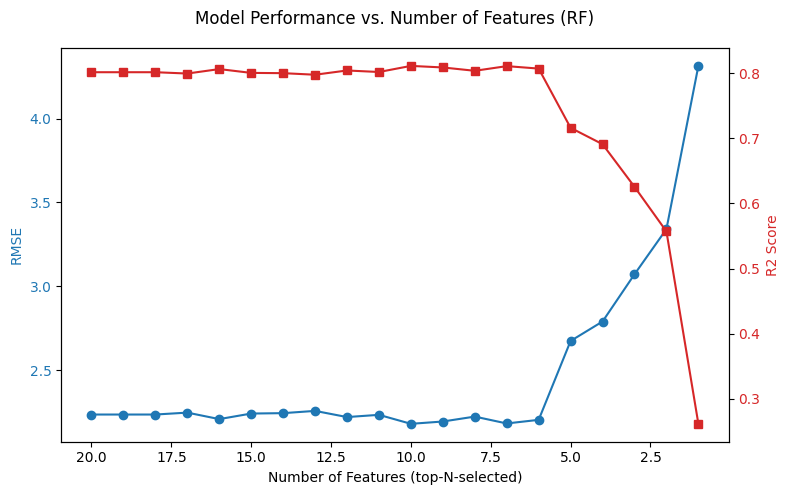

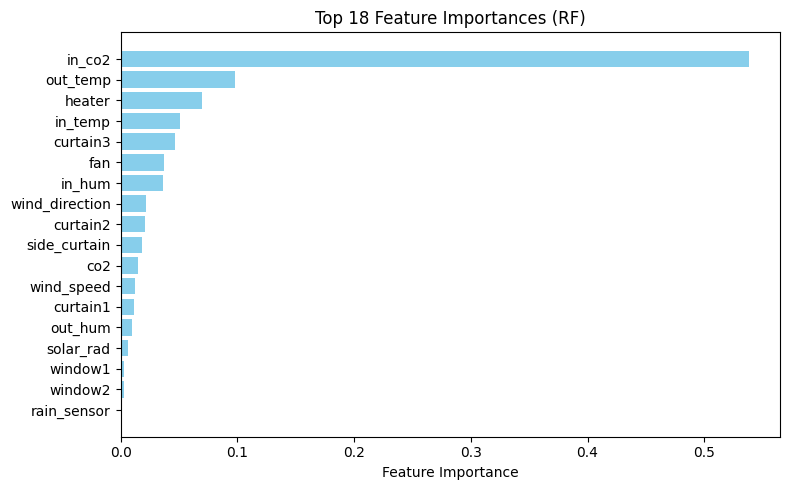

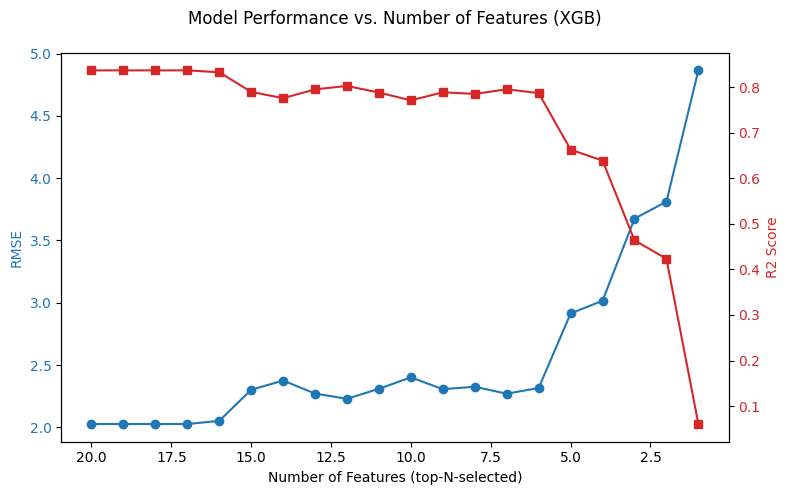

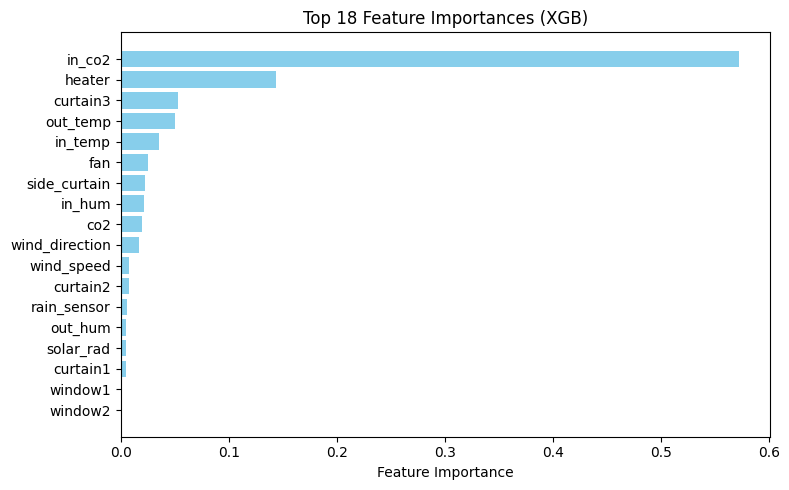

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 123, number of used features: 18
[LightGBM] [Info] Start training from score 2.174134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

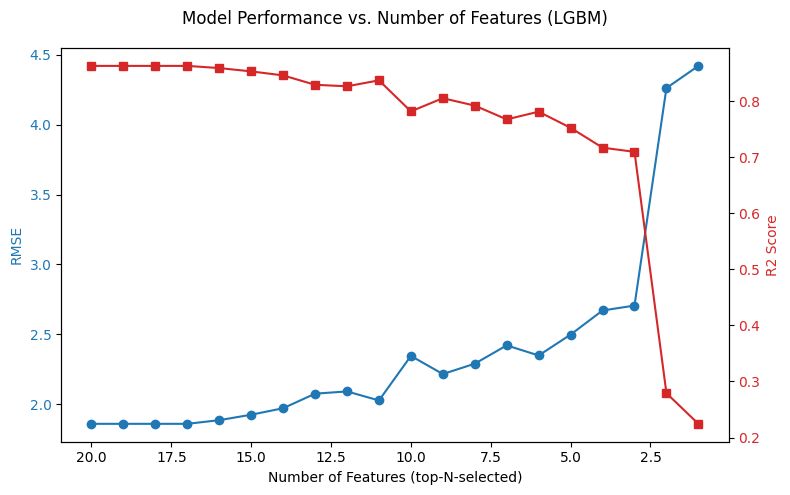

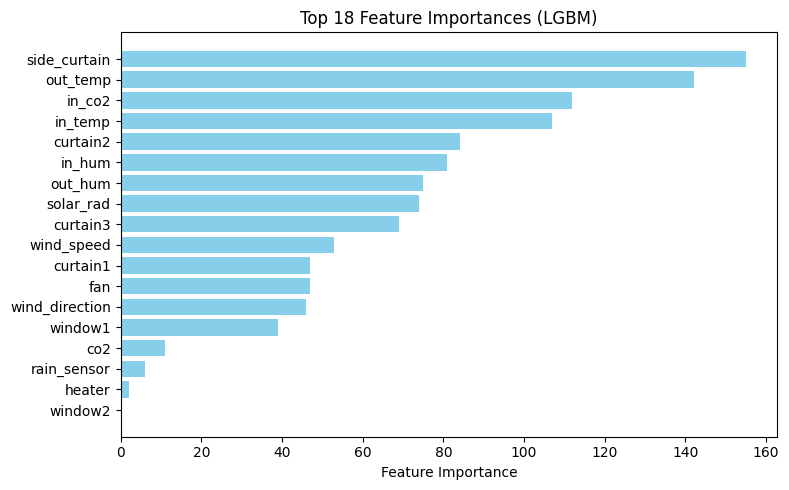

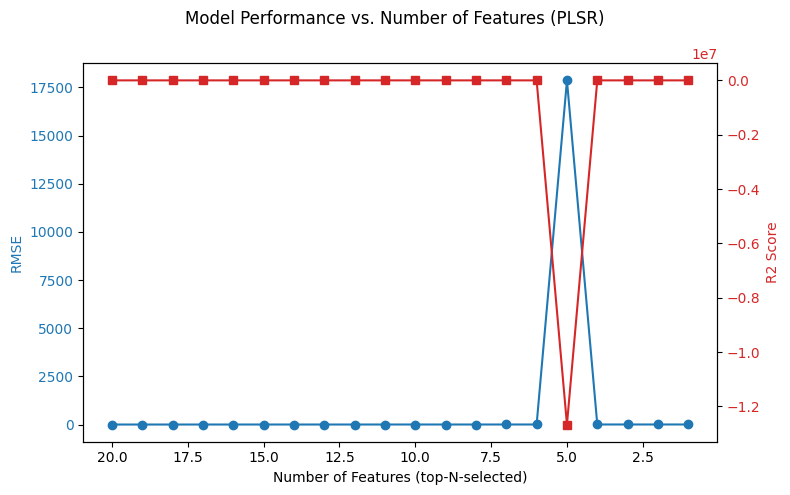

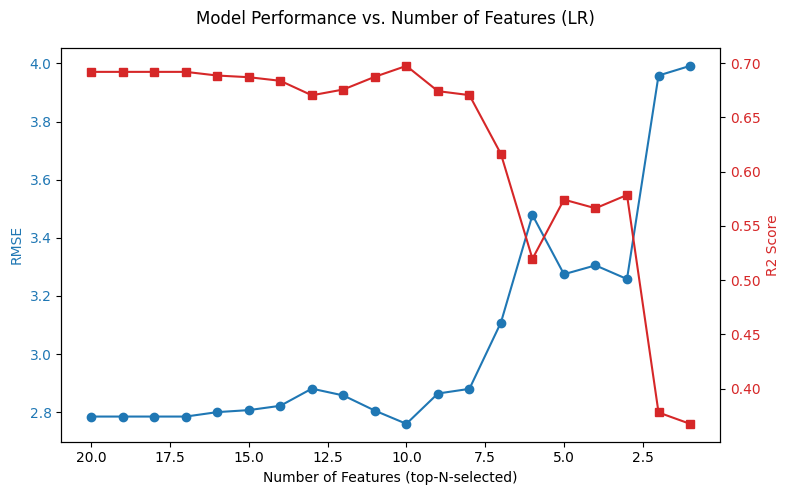

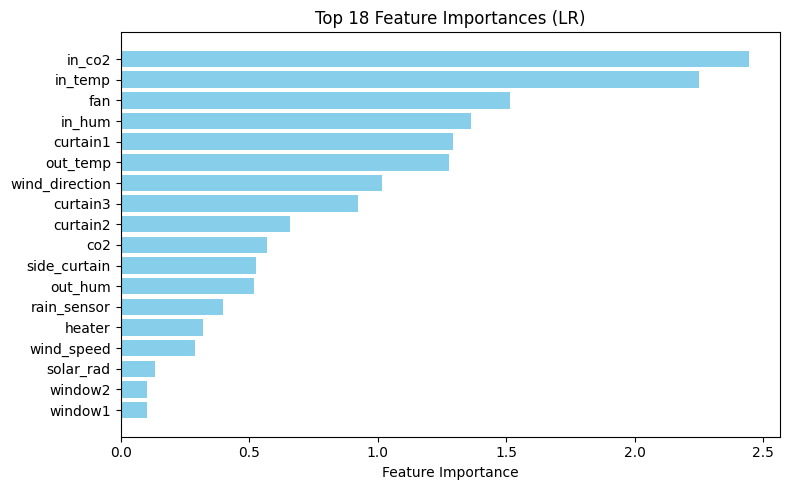

In [5]:
### 머신러닝 모델 성능 곡선 + 피쳐 중요도 ###
models= ['rf', 'xgb', 'lgbm', 'plsr', 'lr']
for model in models:
    result, feat_imp = ml_models_performance_curve(
        X, y, 
        model_type=model, 
        test_size=0.2, 
        random_state=42, 
        max_num_features=20, 
        plot=True,
        scaling='standard',
        model_params={}
    )

## 딥러닝 모델

In [6]:
# (4) 딥러닝용: sample별 전체 시계열 (shape: 샘플수, 시계열길이, feature수)
X_seq, y_seq = make_sequence_by_sample(x_df, y_df, sample_col='Sample_Number', time_col='time', feature_cols=my_features)

# ---- 딥러닝 모델 루프 ----
dl_model_names = ['mlp', 'cnn', 'lstm', 'gru', 'cnn_lstm']
dl_results = []
for mtype in dl_model_names:
    print(f"\n== {mtype.upper()} ==")
    _, rmse, r2 = dl_seq_train(
        X_seq, y_seq,
        model_type=mtype,
        n_units=32, epochs=20, scaling='standard',
        plot=False
    )
    dl_results.append({'model': mtype, 'rmse': rmse, 'r2': r2})
dl_results_df = pd.DataFrame(dl_results)
print('\n[DL Models Performance]')
print(dl_results_df)


== MLP ==


c:\Users\totso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

== CNN ==


c:\Users\totso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

== LSTM ==


c:\Users\totso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

== GRU ==


c:\Users\totso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

== CNN_LSTM ==


c:\Users\totso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

[DL Models Performance]
      model      rmse        r2
0       mlp  2.680762  0.657380
1       cnn  3.300005  0.480811
2      lstm  3.352398  0.464194
3       gru  3.425648  0.440524
4  cnn_lstm  3.164091  0.522697


## 최종 성능 비교

In [7]:
print('[ML Models Performance: by RMSE ascending]')
print(ml_results_df.sort_values('rmse', ascending=True).reset_index(drop=True))

print('\n[DL Models Performance: by RMSE ascending]')
print(dl_results_df.sort_values('rmse', ascending=True).reset_index(drop=True))

[ML Models Performance: by RMSE ascending]
  model      rmse        r2
0  lgbm  1.859391  0.862762
1    rf  2.221213  0.804155
2   xgb  2.242638  0.800359
3  plsr  2.654609  0.720274
4    lr  2.785375  0.692037

[DL Models Performance: by RMSE ascending]
      model      rmse        r2
0       mlp  2.680762  0.657380
1  cnn_lstm  3.164091  0.522697
2       cnn  3.300005  0.480811
3      lstm  3.352398  0.464194
4       gru  3.425648  0.440524
